# Load Packages

In [1]:
import pandas as pd
import numpy as np
import json
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import ast
import os
from os import path
from pandas.plotting import table
import nltk
nltk.download("popular")
from google.colab import output
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
output.clear()

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/NLP_Project/data/raw/'
df1 = pd.read_csv(path + 'anime-planet.csv')
df2 = pd.read_csv(path + 'anime-planet-manga.csv')
df3 = pd.read_csv(path + 'anime-series.csv')

In [4]:
df = pd.concat([df1, df2, df3], ignore_index = True)
df = df.drop(df.columns[[0]], axis = 1).reset_index(drop=True)

In [ ]:
# df.count

<bound method DataFrame.count of                                                               Title  ...                                                                                                                                                                                                                Tags
0                                  Attack on Titan The Final Season  ...                                       ['Action', 'Drama', 'Fantasy', 'Horror', 'Shounen', 'Dark Fantasy', 'Military', 'War', 'Explicit Violence', 'Mature Themes', 'Physical Abuse', 'Suicide', 'Based on a Manga']
1                                  Fullmetal Alchemist: Brotherhood  ...  ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Shounen', 'Conspiracy', 'Death of a Loved One', 'Military', 'Siblings', 'Animal Abuse', 'Mature Themes', 'Violence', 'Based on a Manga', 'Domestic Abuse']
2                               Attack on Titan 3rd Season: Part II  ...                             ['Action', 

# Clean Data

In [6]:
anime_df = df.replace(to_replace='None', value=np.nan).dropna(subset=['Description', 'Tags'])

In [7]:
anime_df.drop_duplicates(subset='Description', keep = False, inplace = True)

In [8]:
anime_df = anime_df.reset_index(drop=True)

In [9]:
anime_df['Description'] = anime_df['Description'].apply(sent_tokenize)

In [10]:
sent_threshold = 3
def remove_short_entries(sentences):
  if len(sentences) < sent_threshold:
    return np.nan

  return ' '.join(sentences)

In [11]:
anime_df['Description'] = anime_df['Description'].apply(remove_short_entries)

In [12]:
anime_df = anime_df.dropna(subset=['Description', 'Tags'])

In [ ]:
# anime_df.count

<bound method DataFrame.count of                                                          Title  ...                                                                                                                                                                                                                Tags
0                             Attack on Titan The Final Season  ...                                       ['Action', 'Drama', 'Fantasy', 'Horror', 'Shounen', 'Dark Fantasy', 'Military', 'War', 'Explicit Violence', 'Mature Themes', 'Physical Abuse', 'Suicide', 'Based on a Manga']
1                             Fullmetal Alchemist: Brotherhood  ...  ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Shounen', 'Conspiracy', 'Death of a Loved One', 'Military', 'Siblings', 'Animal Abuse', 'Mature Themes', 'Violence', 'Based on a Manga', 'Domestic Abuse']
2                          Attack on Titan 3rd Season: Part II  ...                             ['Action', 'Fantasy', 'Horror',

## Visualize document count for each genre 
 

In [13]:
popular_threshold = 12

def seperate_tags(input_df):

  def replace_tag(tags):
    new_tags = []
    for t in tags:
      if t == 'Sci-Fi':
        new_tags.append('Sci Fi')
      elif t == 'BL':
        new_tags.append('Yaoi')
      else:
        new_tags.append(t)

    return new_tags

  df = input_df.copy()
  df['Tags'] = df['Tags'].apply(ast.literal_eval)
  df['Tags'] = df['Tags'].apply(replace_tag)
  df['Tags'] = df['Tags'].apply(set)
  df['Tags'] = df['Tags'].apply(list)

  df = df.explode('Tags')
  group_df = df.groupby('Tags')
  x = group_df.size().reset_index(name='Counts')
  x.sort_values(by=['Counts'], inplace=True, ascending=False)

  popular_tags = list(x['Tags'][:popular_threshold])
  
  tags = []
  values = []
  counts = []
  for tag, tag_df in group_df:
    if tag in popular_tags:
      tags.append(tag)
      values.append(tag_df['Description'])
      counts.append(tag_df['Description'].shape[0])


  # create dataframe
  anime_level_df = pd.DataFrame({'Genre': tags, 
                                'Description': values,
                                'Counts' : counts})
  
  all_genres_df = pd.DataFrame({'Genre': tags, 
                                'Count': counts})
  
  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre") 
  plt.savefig("Anime-Count.png")
  plt.show()

  return anime_level_df, all_genres_df

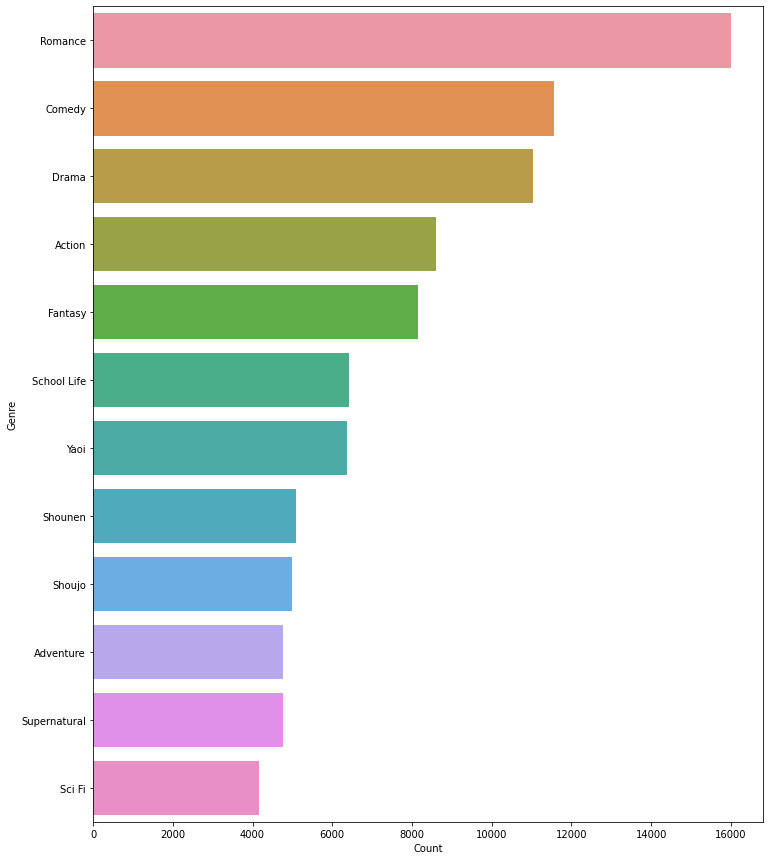

In [14]:
document_level_df, document_count_df = seperate_tags(anime_df)

In [15]:
document_level_df.count

<bound method DataFrame.count of            Genre  ... Counts
0         Action  ...   8613
1      Adventure  ...   4773
2         Comedy  ...  11567
3          Drama  ...  11041
4        Fantasy  ...   8144
5        Romance  ...  15996
6    School Life  ...   6428
7         Sci Fi  ...   4173
8         Shoujo  ...   4978
9        Shounen  ...   5094
10  Supernatural  ...   4763
11          Yaoi  ...   6380

[12 rows x 3 columns]>

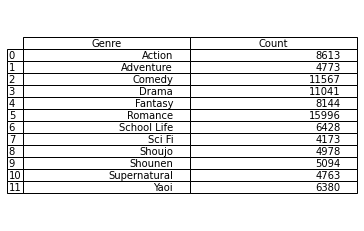

In [17]:
document_count_df

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, document_count_df, loc='center')

plt.savefig('document_count_df.png')

# Save Cleaned Data

In [ ]:
save_path = '/content/drive/MyDrive/NLP_Project/data/clean/'
if not path.exists(save_path):
  os.mkdir(save_path)

document_count_df.to_pickle('document_count_df.pkl')
document_level_df.to_pickle('document_level_df.pkl')
anime_df.to_pickle('anime_df.pkl')

!cp /content/document_count_df.pkl /content/drive/MyDrive/NLP_Project/data/clean
!cp /content/document_level_df.pkl /content/drive/MyDrive/NLP_Project/data/clean
!cp /content/anime_df.pkl /content/drive/MyDrive/NLP_Project/data/clean